# Optimizing Cyclone Shelter Allocation and Expansion in Teknaf Upazila
### Contributors: Riya Parikh, Ayela Chughtai, Rose Dana

### Imports - Data and Grid Loading

In [1]:
# Packages + Solver
using CSV, DataFrames, Statistics
using JuMP
using HiGHS
using CairoMakie

const SOLVER = HiGHS.Optimizer   

HiGHS.Optimizer

In [2]:
# Load Data
grid = CSV.read("grid_pop.csv", DataFrame)
shelters_exist = CSV.read("shelter_final.csv", DataFrame)

# Column Mapping 
# Grid cells (I) 
col_grid_id   = :grid_id
col_latI      = :lat_center
col_lonI      = :lon_center
col_pop       = :pop_cell
col_risk      = :hazard_score   # risk uses hazard_score, not hazard_class

# Existing shelters (J_E)
col_shel_id   = :CS_ID
col_latJE     = :lat
col_lonJE     = :lon
col_capJE     = Symbol("DRRO Capacity")

Symbol("DRRO Capacity")

### Distance Calculations - Setting Candidate and Existing Shelters Onto Grids

In [3]:
# Helper Functions for Dist
deg2rad(x) = x * (pi / 180)

# Haversine distance measures between two lat/lon points in kilometers.
function haversine_km(lat1, lon1, lat2, lon2)
    R = 6371.0  # Earth radius in km
    φ1 = deg2rad(lat1); φ2 = deg2rad(lat2)
    Δφ = deg2rad(lat2 - lat1)
    Δλ = deg2rad(lon2 - lon1)
    a = sin(Δφ/2)^2 + cos(φ1)*cos(φ2)*sin(Δλ/2)^2
    c = 2 * atan(sqrt(a), sqrt(1-a))
    return R * c
end

haversine_km (generic function with 1 method)

In [4]:
# Build Sets + Parameters
# Population cells (I)
I_ids = grid[!, col_grid_id]
latI  = grid[!, col_latI]
lonI  = grid[!, col_lonI]
d     = coalesce.(grid[!, col_pop], 0.0)      # population
r     = coalesce.(grid[!, col_risk], 0.0)     # risk score

nI = length(I_ids)

D_total = sum(d)
R_total = sum(r .* d)

# Existing shelters (J_E)
JE_ids = shelters_exist[!, col_shel_id]
latJE  = shelters_exist[!, col_latJE]
lonJE  = shelters_exist[!, col_lonJE]
uJE    = coalesce.(shelters_exist[!, col_capJE], 0.0)

nJE = length(JE_ids)
JE = 1:nJE

# Candidate shelters (J_N)
# = every grid center (NO filtering, duplicates allowed)
# New shelter capacity = max existing capacity
u_new = maximum(uJE)   # capacity ≤ max existing

JN_ids = ["cand_" * string(I_ids[i]) for i in 1:nI]
latJN  = latI
lonJN  = lonI
uJN    = fill(u_new, nI)

nJN = length(JN_ids)

# Combined shelter set J = J_E ∪ J_N
J_ids = vcat(JE_ids, JN_ids)
latJ  = vcat(latJE, latJN)
lonJ  = vcat(lonJE, lonJN)
u     = vcat(uJE,  uJN)

nJ = length(J_ids)

# candidate indices inside combined list
JN = (nJE+1):nJ

162:832

In [5]:
# Distance Matrix c_{ij}
c = Array{Float64}(undef, nI, nJ)
for i in 1:nI, j in 1:nJ
    c[i,j] = haversine_km(latI[i], lonI[i], latJ[j], lonJ[j])
end

# Hard Max Travel Distance Lmax (policy)
# Originally this was an extension, but model behaviour was odd if not incorporated from the start 
# St people were being assigned to shelters diagonally all the way across the region
Lmax = 11.0   # in km

# M[i,j] = 1 if shelter j is within Lmax of cell i, else 0
M = Array{Int8}(undef, nI, nJ)
for i in 1:nI, j in 1:nJ
    M[i,j] = c[i,j] <= Lmax + 1e-9 ? 1 : 0
end

### Solve 2 Stage Allocation + Location Problem

In [6]:
# Solver for One K
# Stage 1: maximize risk-weighted coverage
# Stage 1b: maximize use of existing shelters
# Stage 2: min distance with Lmax cutoff enforced in ALL stages

function solve_for_K(K::Int; delta_frac=1e-6)

    # Stage 1: Maximize TOTAL risk-weighted coverage S_r
    m1 = Model(SOLVER)
    set_silent(m1)

    @variable(m1, 0 <= x[1:nI, 1:nJ] <= 1)
    @variable(m1, y[1:nJ], Bin)

    for j in JE
        fix(y[j], 1.0; force=true)  # existing always open
    end

    @constraint(m1, [i=1:nI], sum(x[i,j] for j in 1:nJ) <= 1)
    @constraint(m1, [j=1:nJ], sum(d[i]*x[i,j] for i in 1:nI) <= u[j]*y[j])
    @constraint(m1, sum(y[j] for j in JN) <= K)

    # Lmax cutoff
    @constraint(m1, [i=1:nI, j=1:nJ], x[i,j] <= M[i,j] * y[j])

    Sr_expr_m1 = @expression(m1, sum(r[i]*d[i]*x[i,j] for i in 1:nI, j in 1:nJ))
    @objective(m1, Max, Sr_expr_m1)

    optimize!(m1)
    if termination_status(m1) != MOI.OPTIMAL
        error("Stage 1 failed for K=$K (might be infeasible with Lmax=7km)")
    end

    Sr_star = objective_value(m1)
    δSr = delta_frac * R_total

    # Stage 1b: Among max-Sr solutions, maximize EXISTING use
    m1b = Model(SOLVER)
    set_silent(m1b)

    @variable(m1b, 0 <= xb[1:nI, 1:nJ] <= 1)
    @variable(m1b, yb[1:nJ], Bin)

    for j in JE
        fix(yb[j], 1.0; force=true)
    end

    @constraint(m1b, [i=1:nI], sum(xb[i,j] for j in 1:nJ) <= 1)
    @constraint(m1b, [j=1:nJ], sum(d[i]*xb[i,j] for i in 1:nI) <= u[j]*yb[j])
    @constraint(m1b, sum(yb[j] for j in JN) <= K)

    # Lmax cutoff
    @constraint(m1b, [i=1:nI, j=1:nJ], xb[i,j] <= M[i,j] * yb[j])

    Sr_expr_m1b = @expression(m1b, sum(r[i]*d[i]*xb[i,j] for i in 1:nI, j in 1:nJ))
    @constraint(m1b, Sr_expr_m1b >= Sr_star - δSr)

    UE_expr = @expression(m1b, sum(d[i]*xb[i,j] for i in 1:nI, j in JE))
    @objective(m1b, Max, UE_expr)

    optimize!(m1b)
    if termination_status(m1b) != MOI.OPTIMAL
        error("Stage 1b failed for K=$K")
    end

    UE_star = objective_value(m1b)
    δUE = delta_frac * D_total

    # Stage 2: Min distance among max-Sr AND max-UE solutions
    m2 = Model(SOLVER)
    set_silent(m2)

    @variable(m2, 0 <= x2[1:nI, 1:nJ] <= 1)
    @variable(m2, y2[1:nJ], Bin)

    for j in JE
        fix(y2[j], 1.0; force=true)
    end

    @constraint(m2, [i=1:nI], sum(x2[i,j] for j in 1:nJ) <= 1)
    @constraint(m2, [j=1:nJ], sum(d[i]*x2[i,j] for i in 1:nI) <= u[j]*y2[j])
    @constraint(m2, sum(y2[j] for j in JN) <= K)

    # Lmax cutoff
    @constraint(m2, [i=1:nI, j=1:nJ], x2[i,j] <= M[i,j] * y2[j])

    Sr_expr_m2 = @expression(m2, sum(r[i]*d[i]*x2[i,j] for i in 1:nI, j in 1:nJ))
    @constraint(m2, Sr_expr_m2 >= Sr_star - δSr)

    UE_expr_m2 = @expression(m2, sum(d[i]*x2[i,j] for i in 1:nI, j in JE))
    @constraint(m2, UE_expr_m2 >= UE_star - δUE)

    @objective(m2, Min, sum(c[i,j]*d[i]*x2[i,j] for i in 1:nI, j in 1:nJ))

    optimize!(m2)
    if termination_status(m2) != MOI.OPTIMAL
        error("Stage 2 failed for K=$K")
    end

    x_sol = value.(x2)
    y_sol = value.(y2)

    Sr_realized = sum(r[i]*d[i]*x_sol[i,j] for i in 1:nI, j in 1:nJ)
    S_raw       = sum(d[i]*x_sol[i,j] for i in 1:nI, j in 1:nJ)
    UE_realized = sum(d[i]*x_sol[i,j] for i in 1:nI, j in JE)

    alpha_r = R_total > 0 ? Sr_realized / R_total : 0.0
    alpha   = D_total > 0 ? S_raw / D_total       : 0.0
    Z_star  = objective_value(m2)

    return (alpha_r=alpha_r, alpha=alpha, distance=Z_star,
            Sr_star=Sr_star, UE_star=UE_star, UE_realized=UE_realized,
            y=y_sol, x=x_sol)
end

solve_for_K (generic function with 1 method)

#### Understanding Hazard Classes

In [7]:
# Hazard-class prep (classes 1–4)
col_hazclass = :hazard_class
hclass = coalesce.(grid[!, col_hazclass], 0)

haz_classes = 1:4

# totals by class (raw pop and risk-mass)
total_pop_by_class = Dict(h => sum(d[i] for i in 1:nI if hclass[i] == h) for h in haz_classes)
total_riskmass_by_class = Dict(h => sum(r[i]*d[i] for i in 1:nI if hclass[i] == h) for h in haz_classes)

println("Total pop by class: ", total_pop_by_class)
println("Total risk-mass by class: ", total_riskmass_by_class)

# Hazard-class coverage for a specific solution
# Compute hazard-class coverage for a given solution.
# Returns dicts:
# - raw_cov[h]  = covered pop in class h / total pop class h
# - risk_cov[h] = covered riskmass in class h / total riskmass class h

function hazard_class_coverage(sol)
    xK = sol.x
    # served fraction per cell s_i = sum_j x_ij
    s = [sum(xK[i,j] for j in 1:nJ) for i in 1:nI]

    raw_cov  = Dict{Int,Float64}()
    risk_cov = Dict{Int,Float64}()

    for h in haz_classes
        tot_pop_h  = total_pop_by_class[h]
        tot_risk_h = total_riskmass_by_class[h]

        covered_pop_h  = sum(d[i]*s[i] for i in 1:nI if hclass[i] == h)
        covered_risk_h = sum(r[i]*d[i]*s[i] for i in 1:nI if hclass[i] == h)

        raw_cov[h]  = tot_pop_h  > 0 ? covered_pop_h  / tot_pop_h  : 0.0
        risk_cov[h] = tot_risk_h > 0 ? covered_risk_h / tot_risk_h : 0.0
    end
    return raw_cov, risk_cov
end

Total pop by class: Dict(4 => 123923, 2 => 122594, 3 => 142405, 1 => 76142)
Total risk-mass by class: Dict(4 => 24668.602285310284, 2 => 63791.00023895401, 3 => 45042.94259469208, 1 => 61522.72756027419)


hazard_class_coverage (generic function with 1 method)

In [8]:
# Frontier sweep over K (stores hazard-class metrics too)
# Run model for vector of K values and store frontier metrics + hazard-class coverage.
# Returns:
# - frontier_df (wide, one row per K)
# - haz_long_df (long, one row per K per class)

function run_frontier(K_vals::Vector{Int})
    rows = NamedTuple[]
    haz_rows = NamedTuple[]
    total = length(K_vals)

    for (idx, K) in enumerate(K_vals)
        # progress update line
        pct = round(100 * idx / total; digits=1)
        println("\n[$idx/$total | $pct%] Solving K = $K")

        try
            solK = solve_for_K(K)
            open_new = sum(round.(Int, solK.y[j]) for j in JN)

            # hazard class coverage
            raw_cov, risk_cov = hazard_class_coverage(solK)

            push!(rows, (
                K=K,
                alpha_r=solK.alpha_r,
                alpha=solK.alpha,
                distance=solK.distance,
                open_new=open_new,
                status="optimal"
            ))

            for h in haz_classes
                push!(haz_rows, (
                    K=K,
                    hazard_class=h,
                    raw_cov=raw_cov[h],
                    risk_cov=risk_cov[h]
                ))
            end

        catch e
            println("K=$K failed: ", e)
            push!(rows, (
                K=K,
                alpha_r=missing,
                alpha=missing,
                distance=missing,
                open_new=missing,
                status="failed"
            ))
        end
    end

    frontier_df = DataFrame(rows)
    haz_long_df = DataFrame(haz_rows)
    return frontier_df, haz_long_df
end


# choosing K values to sweep 
K_vals = [0, 5, 10, 15, 20, 25, 30]
frontier_df, haz_long_df = run_frontier(K_vals)

# save outputs
CSV.write("frontier_results.csv", frontier_df)
CSV.write("hazard_class_coverage.csv", haz_long_df)

println("Frontier results:")
show(frontier_df, allrows=true, allcols=true)


[1/7 | 14.3%] Solving K = 0

[2/7 | 28.6%] Solving K = 5

[3/7 | 42.9%] Solving K = 10

[4/7 | 57.1%] Solving K = 15

[5/7 | 71.4%] Solving K = 20

[6/7 | 85.7%] Solving K = 25

[7/7 | 100.0%] Solving K = 30
Frontier results:
7×6 DataFrame
 Row │ K      alpha_r   alpha     distance   open_new  status  
     │ Int64  Float64   Float64   Float64    Int64     String  
─────┼─────────────────────────────────────────────────────────
   1 │     0  0.71444   0.533976  1.41213e6         0  optimal
   2 │     5  0.744859  0.560854  1.34688e6         5  optimal
   3 │    10  0.770835  0.587732  1.31485e6        10  optimal
   4 │    15  0.793799  0.61461   1.26943e6        15  optimal
   5 │    20  0.813676  0.641488  1.16427e6        20  optimal
   6 │    25  0.832134  0.668366  1.0767e6         25  optimal
   7 │    30  0.849844  0.695244  9.77223e5        30  optimal

### Plotting

In [27]:
# Elbow K* based on diminishing returns on alpha_r
# Choose K* by diminishing returns on alpha_r.
# eps_gain=0.002 means <0.2% gain per shelter counts as flat.
# window=3 means flat for 3 shelters in a row.

function pick_elbow_K(good_df; eps_gain=0.002, window=3)
    good_df = sort(good_df, :K)
    ar = good_df.alpha_r
    Ks = good_df.K

    d_ar = [ar[t] - ar[t-1] for t in 2:length(ar)]

    for t in 1:(length(d_ar) - window + 1)
        if all(d_ar[t:(t+window-1)] .< eps_gain)
            return Ks[t]
        end
    end
    return Ks[end]
end

good = frontier_df[frontier_df.status .== "optimal", :]
K_star = pick_elbow_K(good; eps_gain=0.002, window=3)

# Looking back from our plots, actually, we believe that K=10 (open 10 new shelters) is sufficient. 
# This allows us to cover all of group 1 and 2 (highest risk groups), while still covering over 50% of risk group 3. 
# Risk group 4 is almost never affacted by cyclones due to their positioning releative to the sea and their elevation, 
# so they are not our priority. 

K_star = 10

println("\nElbow-selected K* = ", K_star)


Elbow-selected K* = 10


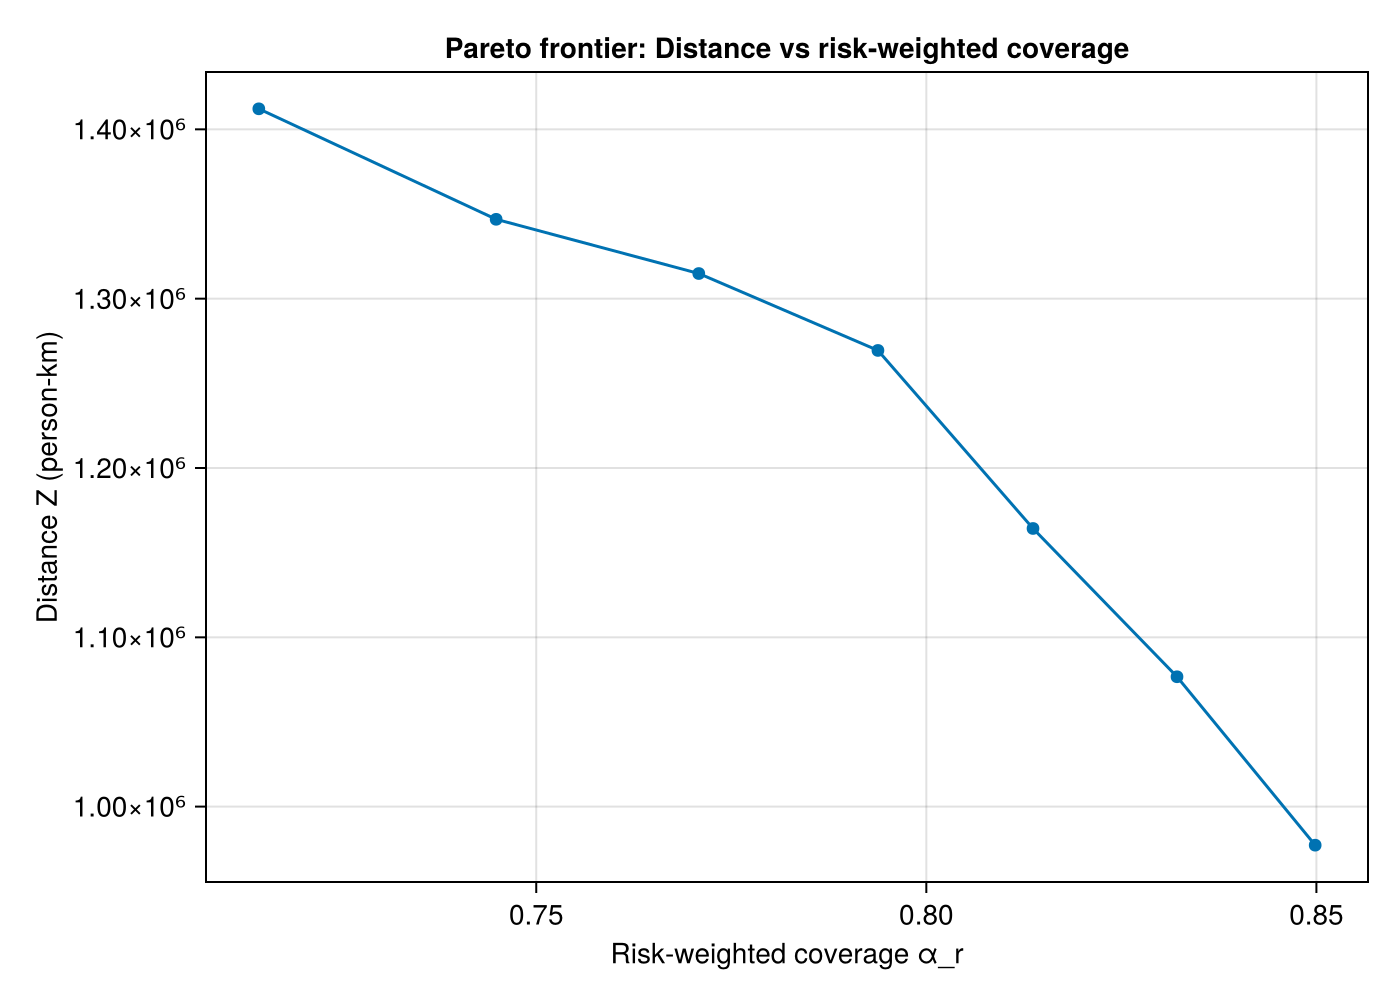

In [28]:
# Frontier plots + Pareto curves
good = sort(good, :K)

# alpha_r vs K
fig1 = Figure(size=(700,450))
ax1 = Axis(fig1[1,1], xlabel="K (max new shelters)", ylabel="Risk-weighted coverage α_r",
           title="α_r vs K")
lines!(ax1, good.K, good.alpha_r)
scatter!(ax1, good.K, good.alpha_r)
vlines!(ax1, [K_star], linestyle=:dash)
fig1

# alpha vs K
fig2 = Figure(size=(700,450))
ax2 = Axis(fig2[1,1], xlabel="K (max new shelters)", ylabel="Raw coverage α",
           title="α vs K")
lines!(ax2, good.K, good.alpha)
scatter!(ax2, good.K, good.alpha)
vlines!(ax2, [K_star], linestyle=:dash)
fig2

# distance vs K
fig3 = Figure(size=(700,450))
ax3 = Axis(fig3[1,1], xlabel="K (max new shelters)", ylabel="Total distance Z (person-km)",
           title="Distance objective vs K")
lines!(ax3, good.K, good.distance)
scatter!(ax3, good.K, good.distance)
vlines!(ax3, [K_star], linestyle=:dash)
fig3

# Pareto: distance vs raw alpha
fig4 = Figure(size=(700,500))
ax4 = Axis(fig4[1,1], xlabel="Raw coverage α", ylabel="Distance Z (person-km)",
           title="Pareto frontier: Distance vs raw coverage")
lines!(ax4, good.alpha, good.distance)
scatter!(ax4, good.alpha, good.distance)
fig4

# Pareto: distance vs alpha_r
fig5 = Figure(size=(700,500))
ax5 = Axis(fig5[1,1], xlabel="Risk-weighted coverage α_r", ylabel="Distance Z (person-km)",
           title="Pareto frontier: Distance vs risk-weighted coverage")
lines!(ax5, good.alpha_r, good.distance)
scatter!(ax5, good.alpha_r, good.distance)
fig5

In [29]:
fig1

In [30]:
fig2

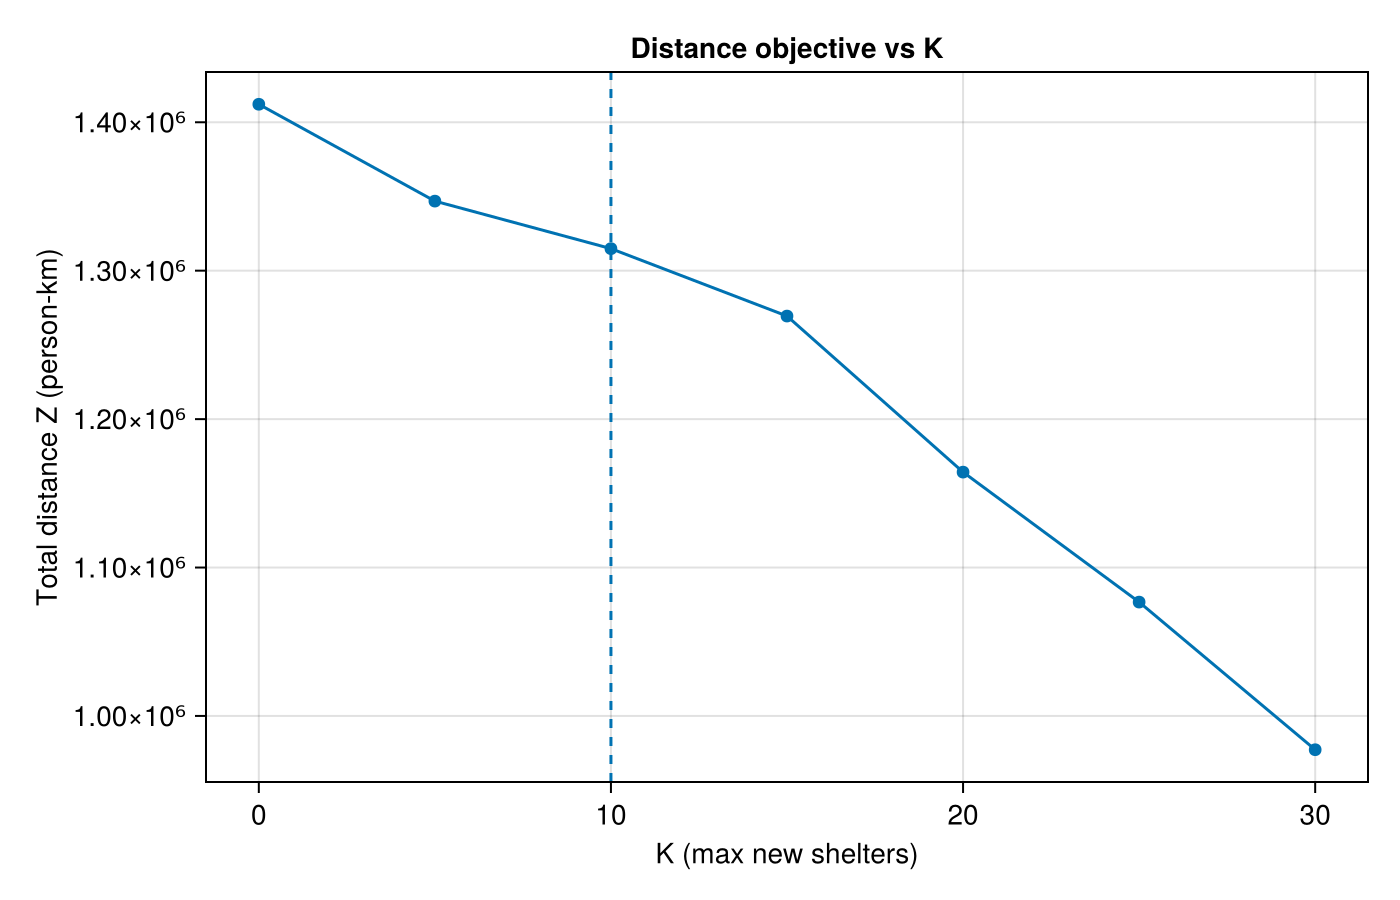

In [31]:
fig3

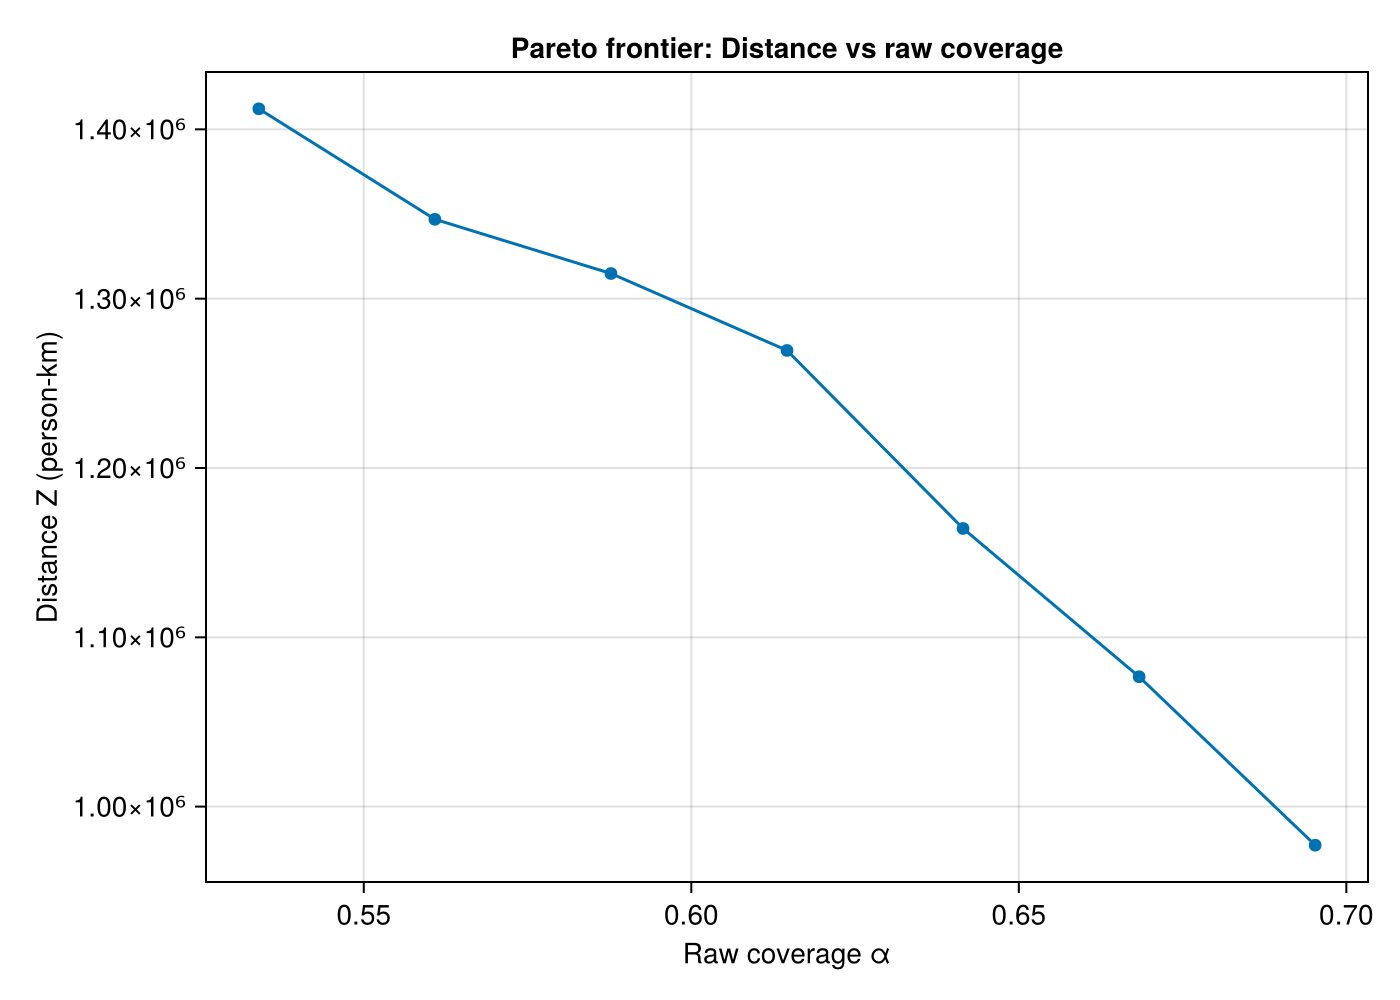

In [32]:
fig4

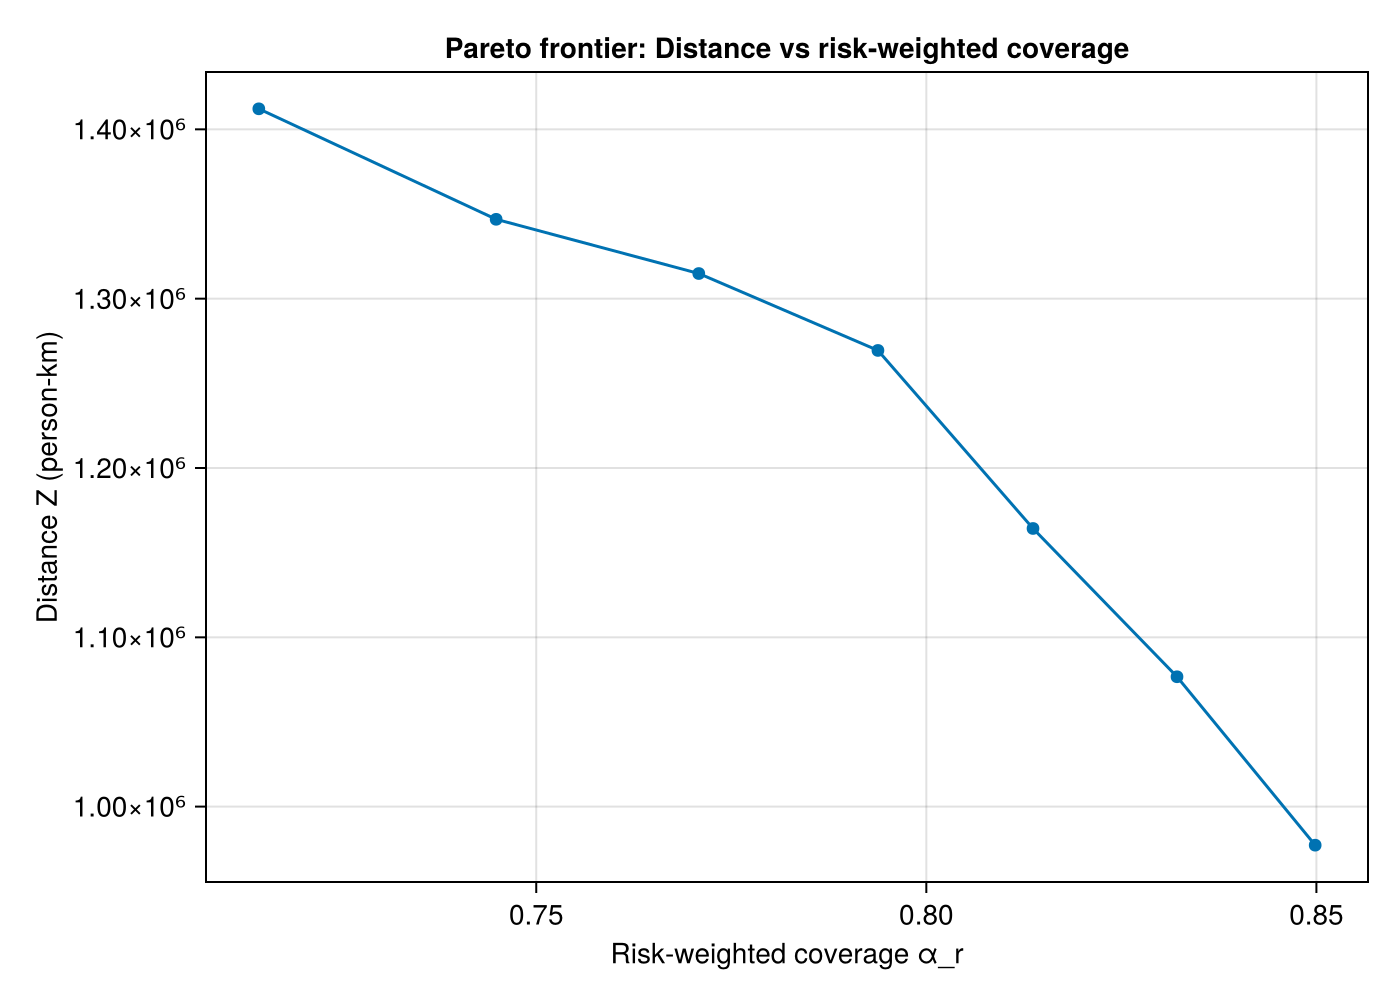

In [33]:
fig5

In [34]:
good = sort(good, :K)

total_pop_by_class = Dict(4 => 123923, 2 => 122594, 3 => 142405, 1 => 76142)
denom = sum(values(total_pop_by_class))   # = 465_064

good.avg_distance = good.distance ./ denom

# avg distance vs K  (fig3a)
fig3a = Figure(size=(700,450))
ax3a = Axis(fig3a[1,1],
    xlabel="K (max new shelters)",
    ylabel="Avg distance (km per person)",
    title="Average distance vs K"
)
lines!(ax3a, good.K, good.avg_distance)
scatter!(ax3a, good.K, good.avg_distance)
vlines!(ax3a, [K_star], linestyle=:dash)
fig3a

# Pareto: avg distance vs raw alpha (fig4a)
fig4a = Figure(size=(700,500))
ax4a = Axis(fig4a[1,1],
    xlabel="Raw coverage α",
    ylabel="Avg distance (km per person)",
    title="Pareto frontier: Avg distance vs raw coverage"
)
lines!(ax4a, good.alpha, good.avg_distance)
scatter!(ax4a, good.alpha, good.avg_distance)
fig4a

# Pareto: avg distance vs alpha_r (fig5a)
fig5a = Figure(size=(700,500))
ax5a = Axis(fig5a[1,1],
    xlabel="Risk-weighted coverage α_r",
    ylabel="Avg distance (km per person)",
    title="Pareto frontier: Avg distance vs risk-weighted coverage"
)
lines!(ax5a, good.alpha_r, good.avg_distance)
scatter!(ax5a, good.alpha_r, good.avg_distance)
fig5a

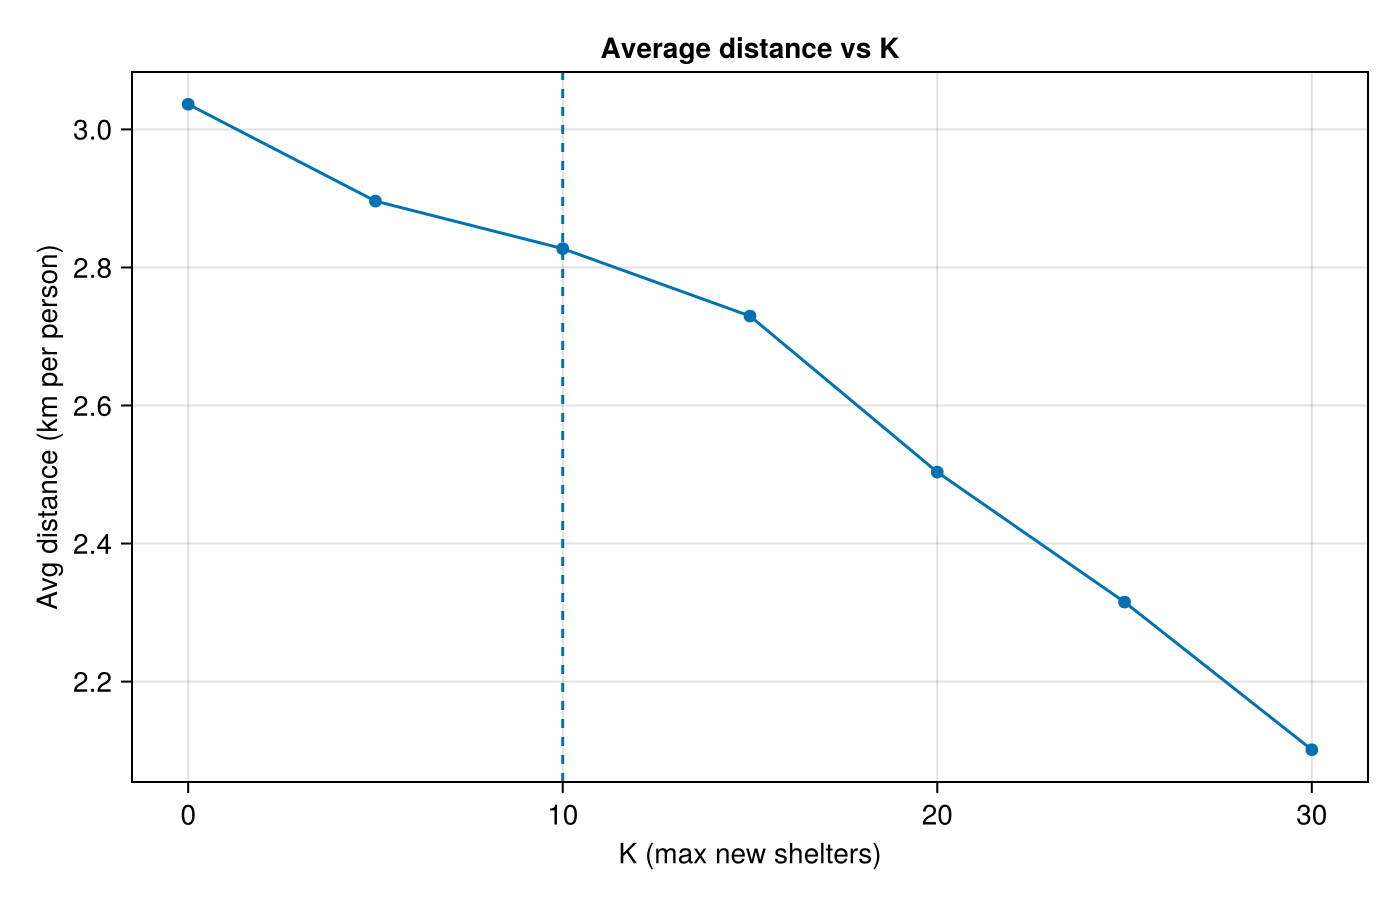

In [35]:
fig3a

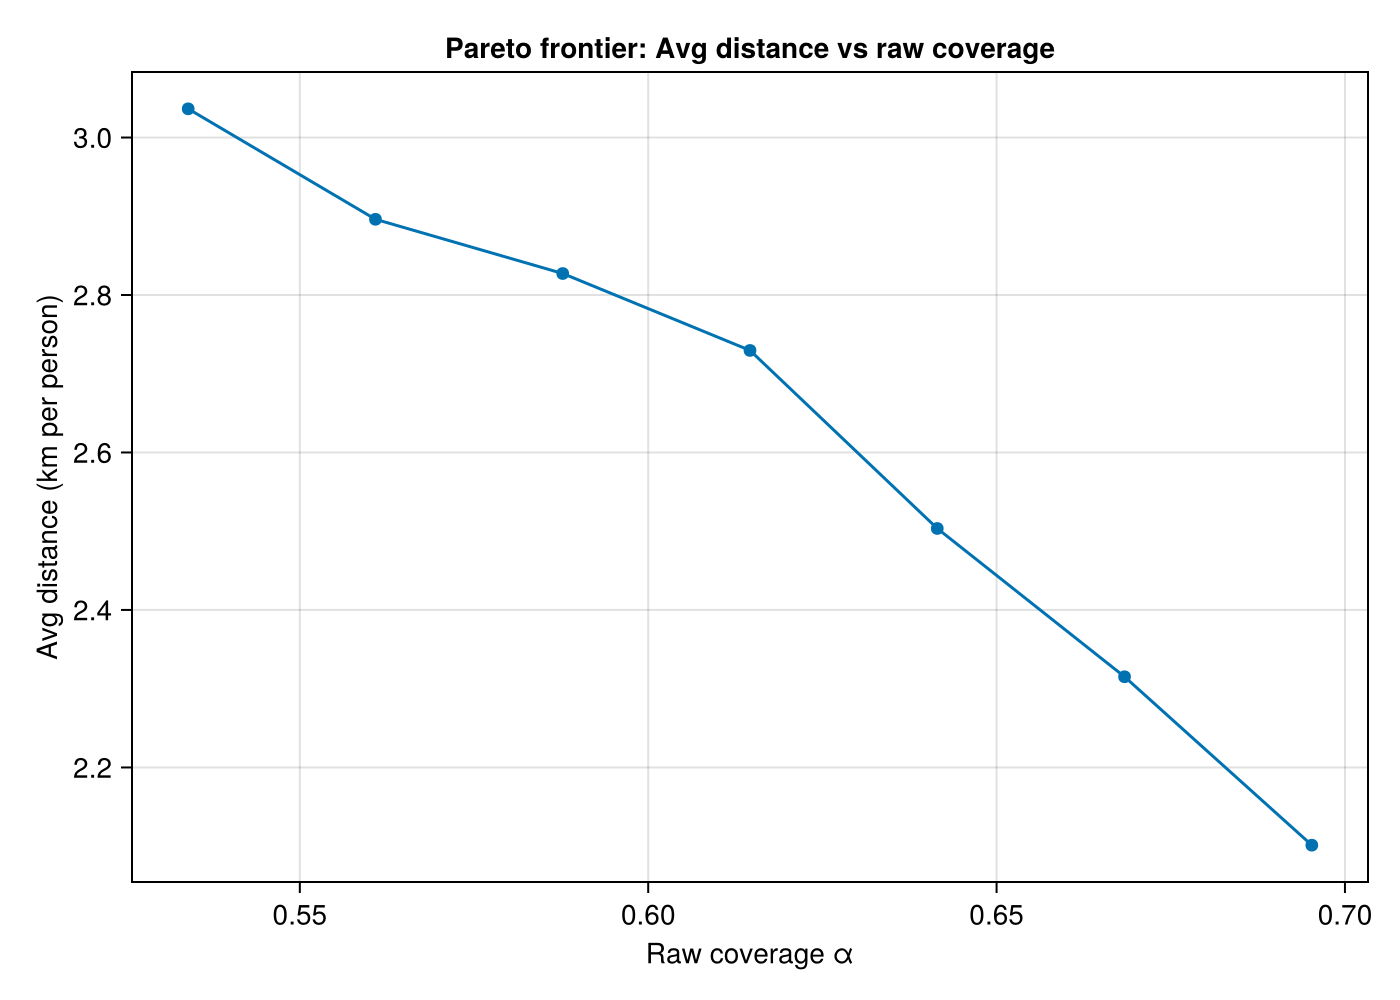

In [36]:
fig4a

In [37]:
fig5a

In [11]:
# Hazard-class coverage plots (raw + risk) vs K
haz_good = haz_long_df[in.(haz_long_df.K, Ref(good.K)), :]

# raw coverage by class vs K
fig6 = Figure(size=(750,500))
ax6 = Axis(fig6[1,1], xlabel="K", ylabel="Raw coverage within class",
           title="Raw coverage by hazard class")
for h in haz_classes
    sub = haz_good[haz_good.hazard_class .== h, :]
    lines!(ax6, sub.K, sub.raw_cov, label="Class $h")
    scatter!(ax6, sub.K, sub.raw_cov)
end
Legend(fig6[1,2], ax6)
fig6

# risk-weighted coverage by class vs K
fig7 = Figure(size=(750,500))
ax7 = Axis(fig7[1,1], xlabel="K", ylabel="Risk-weighted coverage within class",
           title="Risk-weighted coverage by hazard class")
for h in haz_classes
    sub = haz_good[haz_good.hazard_class .== h, :]
    lines!(ax7, sub.K, sub.risk_cov, label="Class $h")
    scatter!(ax7, sub.K, sub.risk_cov)
end
Legend(fig7[1,2], ax7)
fig7

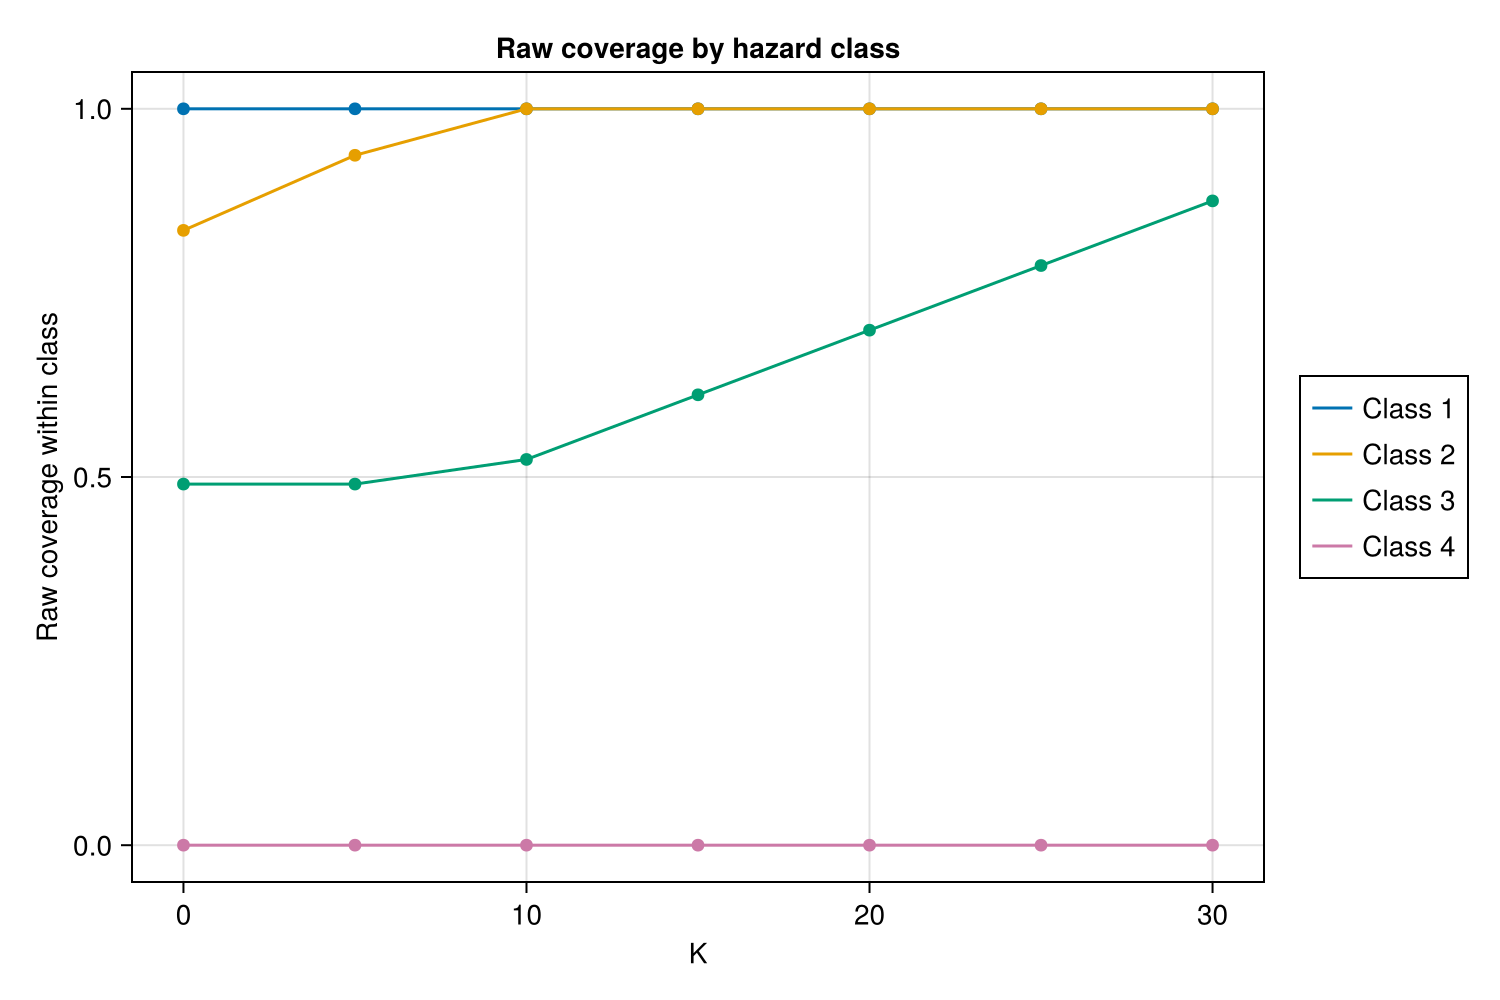

In [19]:
fig6

In [20]:
fig7

In [39]:
# Print hazard-class coverage table for a specific K.
function show_class_coverage(K::Int)
    sub = haz_long_df[haz_long_df.K .== K, :]
    println("Hazard-class coverage for K=$K")
    show(sub, allrows=true, allcols=true)
    return sub
end

# Use like this:
# show_class_coverage(0)
# show_class_coverage(K_star)

show_class_coverage (generic function with 1 method)

In [40]:
show_class_coverage(0)

Hazard-class coverage for K=0
4×4 DataFrame
 Row │ K      hazard_class  raw_cov   risk_cov 
     │ Int64  Int64         Float64   Float64  
─────┼─────────────────────────────────────────
   1 │     0             1  1.0       1.0
   2 │     0             2  0.834935  0.856552
   3 │     0             3  0.490383  0.514415
   4 │     0             4  0.0       0.0

4×4 DataFrame
 Row │ K      hazard_class  raw_cov   risk_cov 
     │ Int64  Int64         Float64   Float64  
─────┼─────────────────────────────────────────
   1 │     0             1  1.0       1.0
   2 │     0             2  0.834935  0.856552
   3 │     0             3  0.490383  0.514415
   4 │     0             4  0.0       0.0

In [41]:
show_class_coverage(K_star)

Hazard-class coverage for K=10
4×4 DataFrame
 Row │ K      hazard_class  raw_cov   risk_cov 
     │ Int64  Int64         Float64   Float64  
─────┼─────────────────────────────────────────
   1 │    10             1  1.0       1.0
   2 │    10             2  1.0       1.0
   3 │    10             3  0.523837  0.555436
   4 │    10             4  0.0       0.0

4×4 DataFrame
 Row │ K      hazard_class  raw_cov   risk_cov 
     │ Int64  Int64         Float64   Float64  
─────┼─────────────────────────────────────────
   1 │    10             1  1.0       1.0
   2 │    10             2  1.0       1.0
   3 │    10             3  0.523837  0.555436
   4 │    10             4  0.0       0.0

#### Baseline (K=0) vs Elbow-best Maps - these are most useful for comparison!

In [50]:
# Baseline (K=0) vs elbow-best maps
function plot_coverage_maps(sol; title_prefix="")
    # served fraction s_i
    s = [sum(sol.x[i,j] for j in 1:nJ) for i in 1:nI]

    raw_color = s
    risk_color = r .* s
    risk_color_norm = maximum(risk_color) > 0 ? risk_color ./ maximum(risk_color) : risk_color

    open_mask = round.(Int, sol.y) .== 1
    new_mask  = [j in JN for j in 1:nJ]
    open_existing = open_mask .& .!new_mask
    open_new      = open_mask .& new_mask

    fig = Figure(size=(1200,520))

    ax1 = Axis(fig[1,1], aspect=DataAspect(),
        title=title_prefix * "Raw coverage (served fraction)",
        xlabel="Longitude", ylabel="Latitude")

    sc1 = scatter!(ax1, lonI, latI;
        color=raw_color, colormap=:viridis, markersize=5, alpha=0.95)

    scatter!(ax1, lonJ[open_existing], latJ[open_existing];
        marker=:x, markersize=14, color=:red, label="Existing shelters")
    scatter!(ax1, lonJ[open_new], latJ[open_new];
        marker=:x, markersize=14, color=:teal, label="New shelters")

    Colorbar(fig[1,2], sc1)   # pass plot handle, not axis


    ax2 = Axis(fig[1,3], aspect=DataAspect(),
        title=title_prefix * "Risk-weighted coverage intensity",
        xlabel="Longitude", ylabel="Latitude")

    sc2 = scatter!(ax2, lonI, latI;
        color=risk_color_norm, colormap=:magma, markersize=5, alpha=0.95)

    scatter!(ax2, lonJ[open_existing], latJ[open_existing];
        marker=:x, markersize=14, color=:red, label="Existing shelters")
    scatter!(ax2, lonJ[open_new], latJ[open_new];
        marker=:x, markersize=14, color=:teal, label="New shelters")

    Colorbar(fig[1,4], sc2)   
    Legend(fig[1,5], ax2)     # outside legend

    fig
end

function plot_assignments(sol; title="", flow_thresh=100)
    rows = NamedTuple[]
    for i in 1:nI, j in 1:nJ
        if sol.x[i,j] > 1e-6
            push!(rows, (i=i, j=j, pop_assigned=d[i]*sol.x[i,j]))
        end
    end
    assign_df = DataFrame(rows)
    assign_plot = assign_df[assign_df.pop_assigned .>= flow_thresh, :]

    open_mask = round.(Int, sol.y) .== 1
    new_mask  = [j in JN for j in 1:nJ]
    open_existing = open_mask .& .!new_mask
    open_new      = open_mask .& new_mask

    fig = Figure(size=(1050,720))
    ax  = Axis(fig[1,1], aspect=DataAspect(),
               xlabel="Longitude", ylabel="Latitude",
               title=title)

    for row in eachrow(assign_plot)
        i=row.i; j=row.j
        lines!(ax, [lonI[i], lonJ[j]], [latI[i], latJ[j]];
            linewidth=0.6, color=(:black, 0.12))
    end

    scatter!(ax, lonI, latI;
        markersize = 2 .+ 8 .* (d ./ maximum(d)),
        color = r, colormap=:viridis, alpha=0.75,
        label="Grid cells (risk color)"
    )

    scatter!(ax, lonJ[open_existing], latJ[open_existing];
        marker=:x, markersize=14, color=:red, label="Existing shelters")
    scatter!(ax, lonJ[open_new], latJ[open_new];
        marker=:x, markersize=14, color=:teal, label="New shelters")

    Legend(fig[1,2], ax)
    fig
end

function plot_dominant_map(sol; title="", return_tables=false, show_nondominant_open=true)
    # build dominant assignment per region i
    dom_rows = NamedTuple[]
    for i in 1:nI
        assigned_pop_i = sum(d[i] * sol.x[i,j] for j in 1:nJ)
        if assigned_pop_i <= 1e-6
            continue
        end
        j_dom = argmax(sol.x[i, :])
        push!(dom_rows, (i=i, lon=lonI[i], lat=latI[i], pop=d[i], dom_j=j_dom))
    end
    dom_df = DataFrame(dom_rows)

    # unique dominant shelters and a stable ordering
    uniq_shelters = sort(unique(dom_df.dom_j))
    group_id = Dict(j => k for (k,j) in enumerate(uniq_shelters))
    dom_df.group = [group_id[j] for j in dom_df.dom_j]

    G = length(uniq_shelters)
    colors = cgrad(:tab20, G; categorical=true)  # discrete palette
    shel_group = collect(1:G)                   # 1..G for coloring X's

    # masks for open / new / existing
    open_mask = round.(Int, sol.y) .== 1
    new_mask  = [j in JN for j in 1:nJ]
    open_existing = open_mask .& .!new_mask
    open_new      = open_mask .& new_mask

    dom_set = Set(uniq_shelters)
    other_open_inds = show_nondominant_open ? 
        [j for j in 1:nJ if open_mask[j] && !(j in dom_set)] : Int[]

    # plot
    fig = Figure(size=(1050,720))
    ax  = Axis(fig[1,1], aspect=DataAspect(),
               xlabel="Longitude", ylabel="Latitude",
               title=title)

    # regions colored by dominant shelter  (no legend needed for this)
    scatter!(ax, dom_df.lon, dom_df.lat;
        color=dom_df.group, colormap=colors,
        markersize=2 .+ 8 .* (dom_df.pop ./ maximum(dom_df.pop)),
        alpha=0.9)

    # dominant shelters as X's colored by their group
    scatter!(ax, lonJ[uniq_shelters], latJ[uniq_shelters];
        color=shel_group, colormap=colors,
        marker=:x, markersize=18, strokecolor=:black, strokewidth=0.8,
        label="Dominant shelters")

    # show other open shelters faintly (still X)
    if show_nondominant_open && !isempty(other_open_inds)
        scatter!(ax, lonJ[other_open_inds], latJ[other_open_inds];
            marker=:x, markersize=12, color=(:gray, 0.25),
            label="Other open shelters")
    end

    Legend(fig[1,2], ax)

    # tables to tell "which shelter dominates where"
    # summary: how many cells + total dominated pop per shelter
    shelter_summary = combine(groupby(dom_df, :dom_j),
        nrow => :n_cells,
        :pop => sum => :dominated_pop
    )
    shelter_summary.lon = lonJ[shelter_summary.dom_j]
    shelter_summary.lat = latJ[shelter_summary.dom_j]
    shelter_summary.is_new = [j in JN for j in shelter_summary.dom_j]
    sort!(shelter_summary, :dominated_pop, rev=true)

    if return_tables
        return fig, dom_df, shelter_summary
    else
        return fig
    end
end

# solve baseline + elbow best - alr ran once dont need to again!
# sol_base  = solve_for_K(0)
# sol_star  = solve_for_K(K_star)

println("\nBaseline K=0: alpha_r=", sol_base.alpha_r,
        " alpha=", sol_base.alpha, " Z=", sol_base.distance)
println("Elbow best K=$K_star: alpha_r=", sol_star.alpha_r,
        " alpha=", sol_star.alpha, " Z=", sol_star.distance)

plot_coverage_maps(sol_base; title_prefix="Baseline (K=0): ")
plot_assignments(sol_base; title="Assignments baseline (K=0)")
plot_dominant_map(sol_base; title="Dominant regions baseline (K=0)")

plot_coverage_maps(sol_star; title_prefix="Elbow best (K=$K_star): ")
plot_assignments(sol_star; title="Assignments elbow-best (K=$K_star)")
plot_dominant_map(sol_star; title="Dominant regions elbow-best (K=$K_star)")


Baseline K=0: alpha_r=0.7144398315077909 alpha=0.5339759688989042 Z=1.412132251705255e6
Elbow best K=10: alpha_r=0.7708345652865948 alpha=0.5877320110780452 Z=1.3148536642687463e6


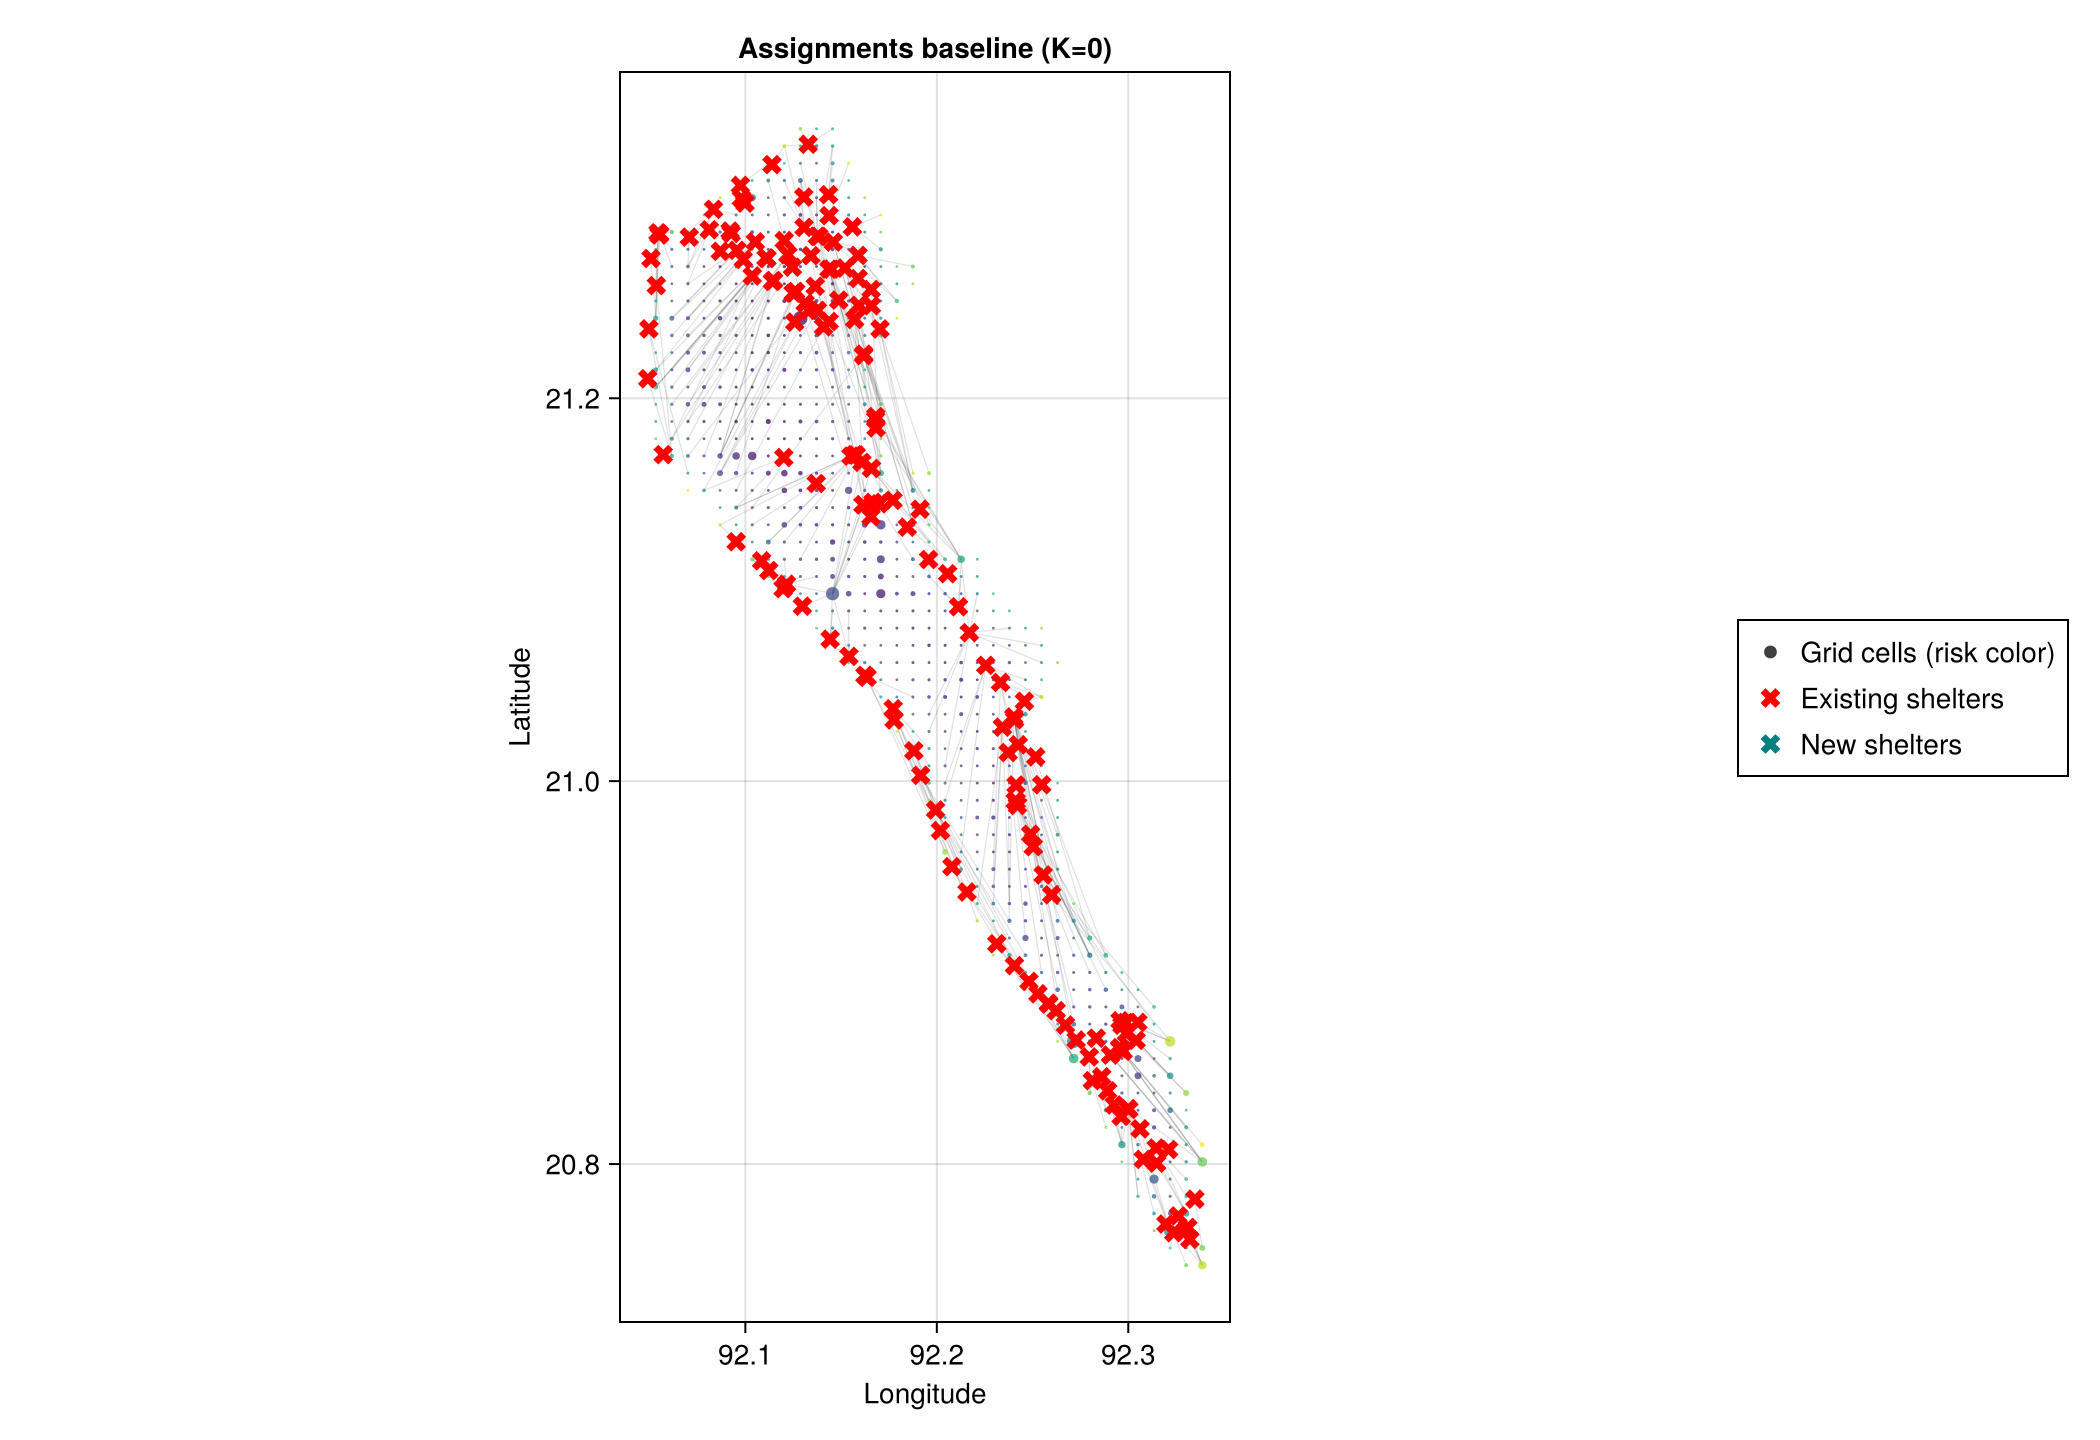

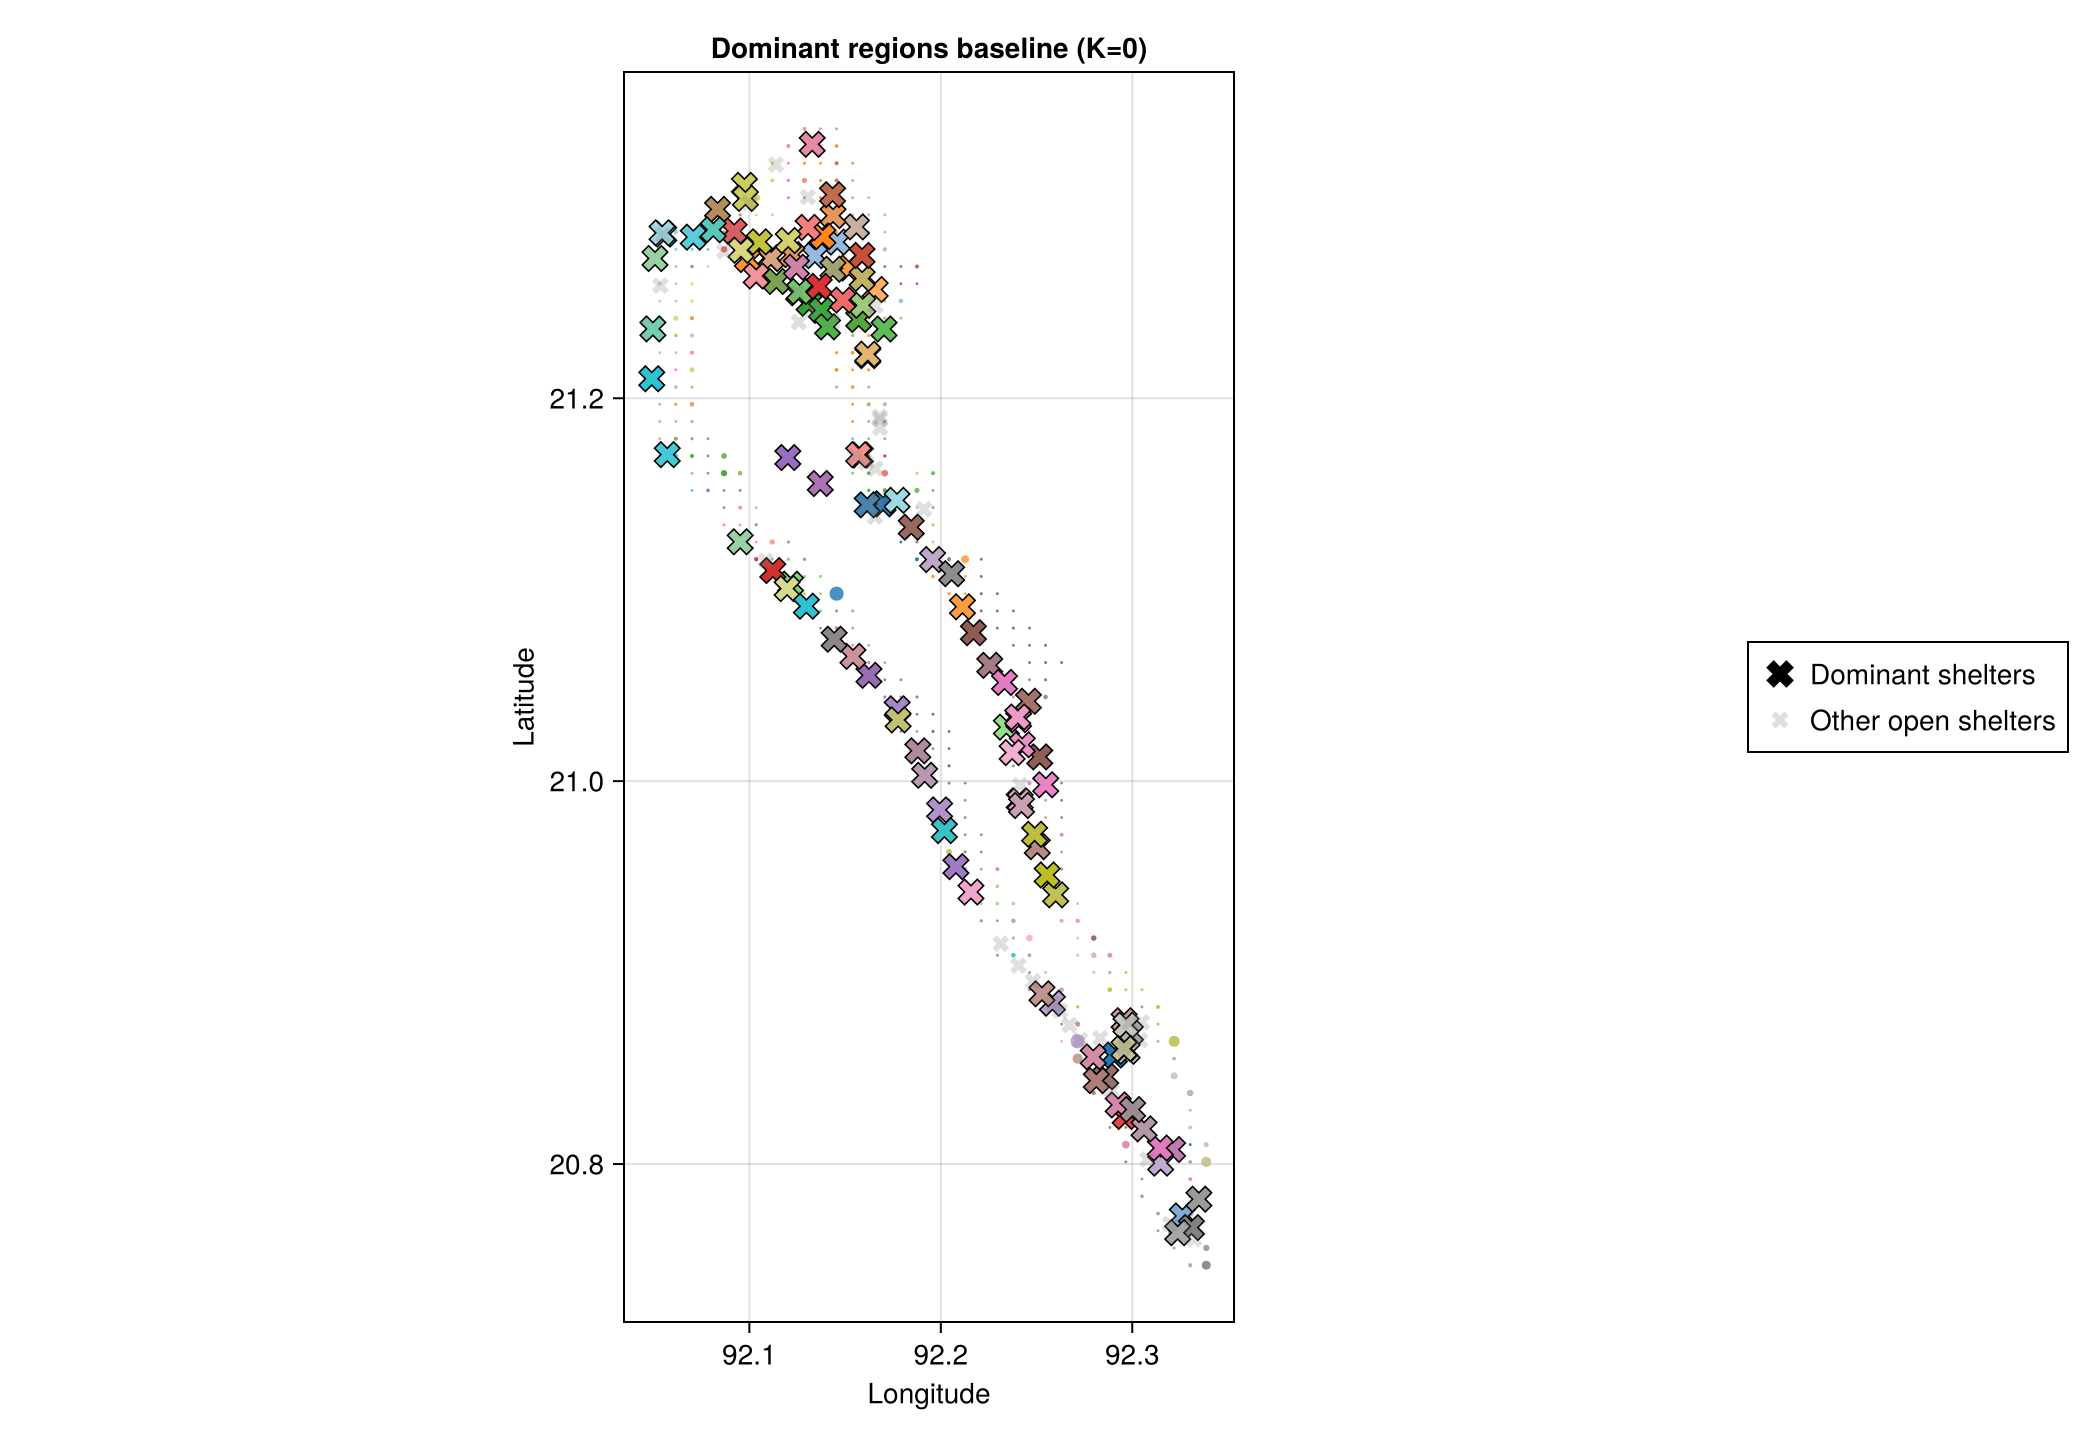

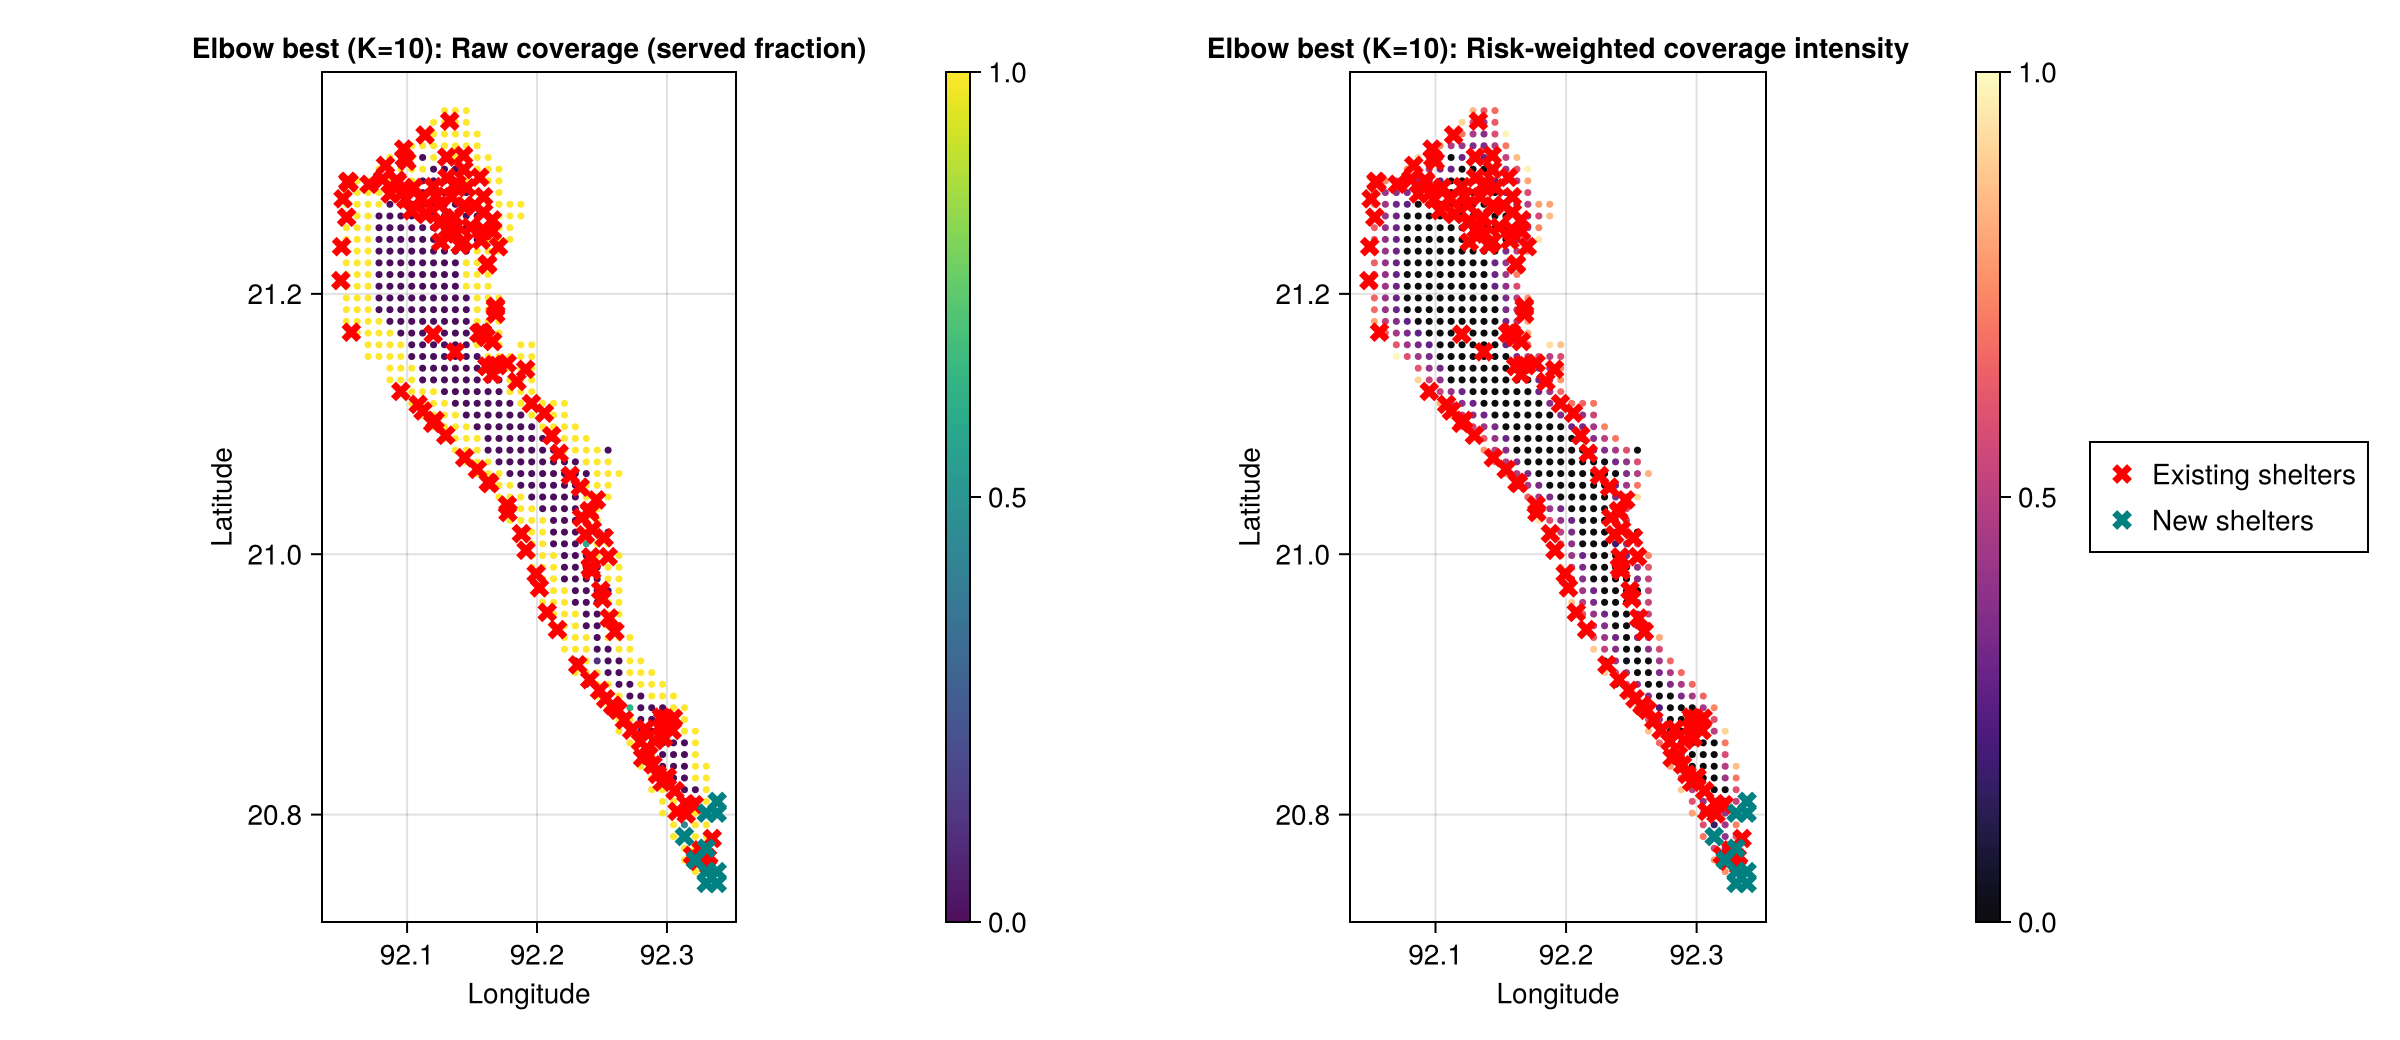

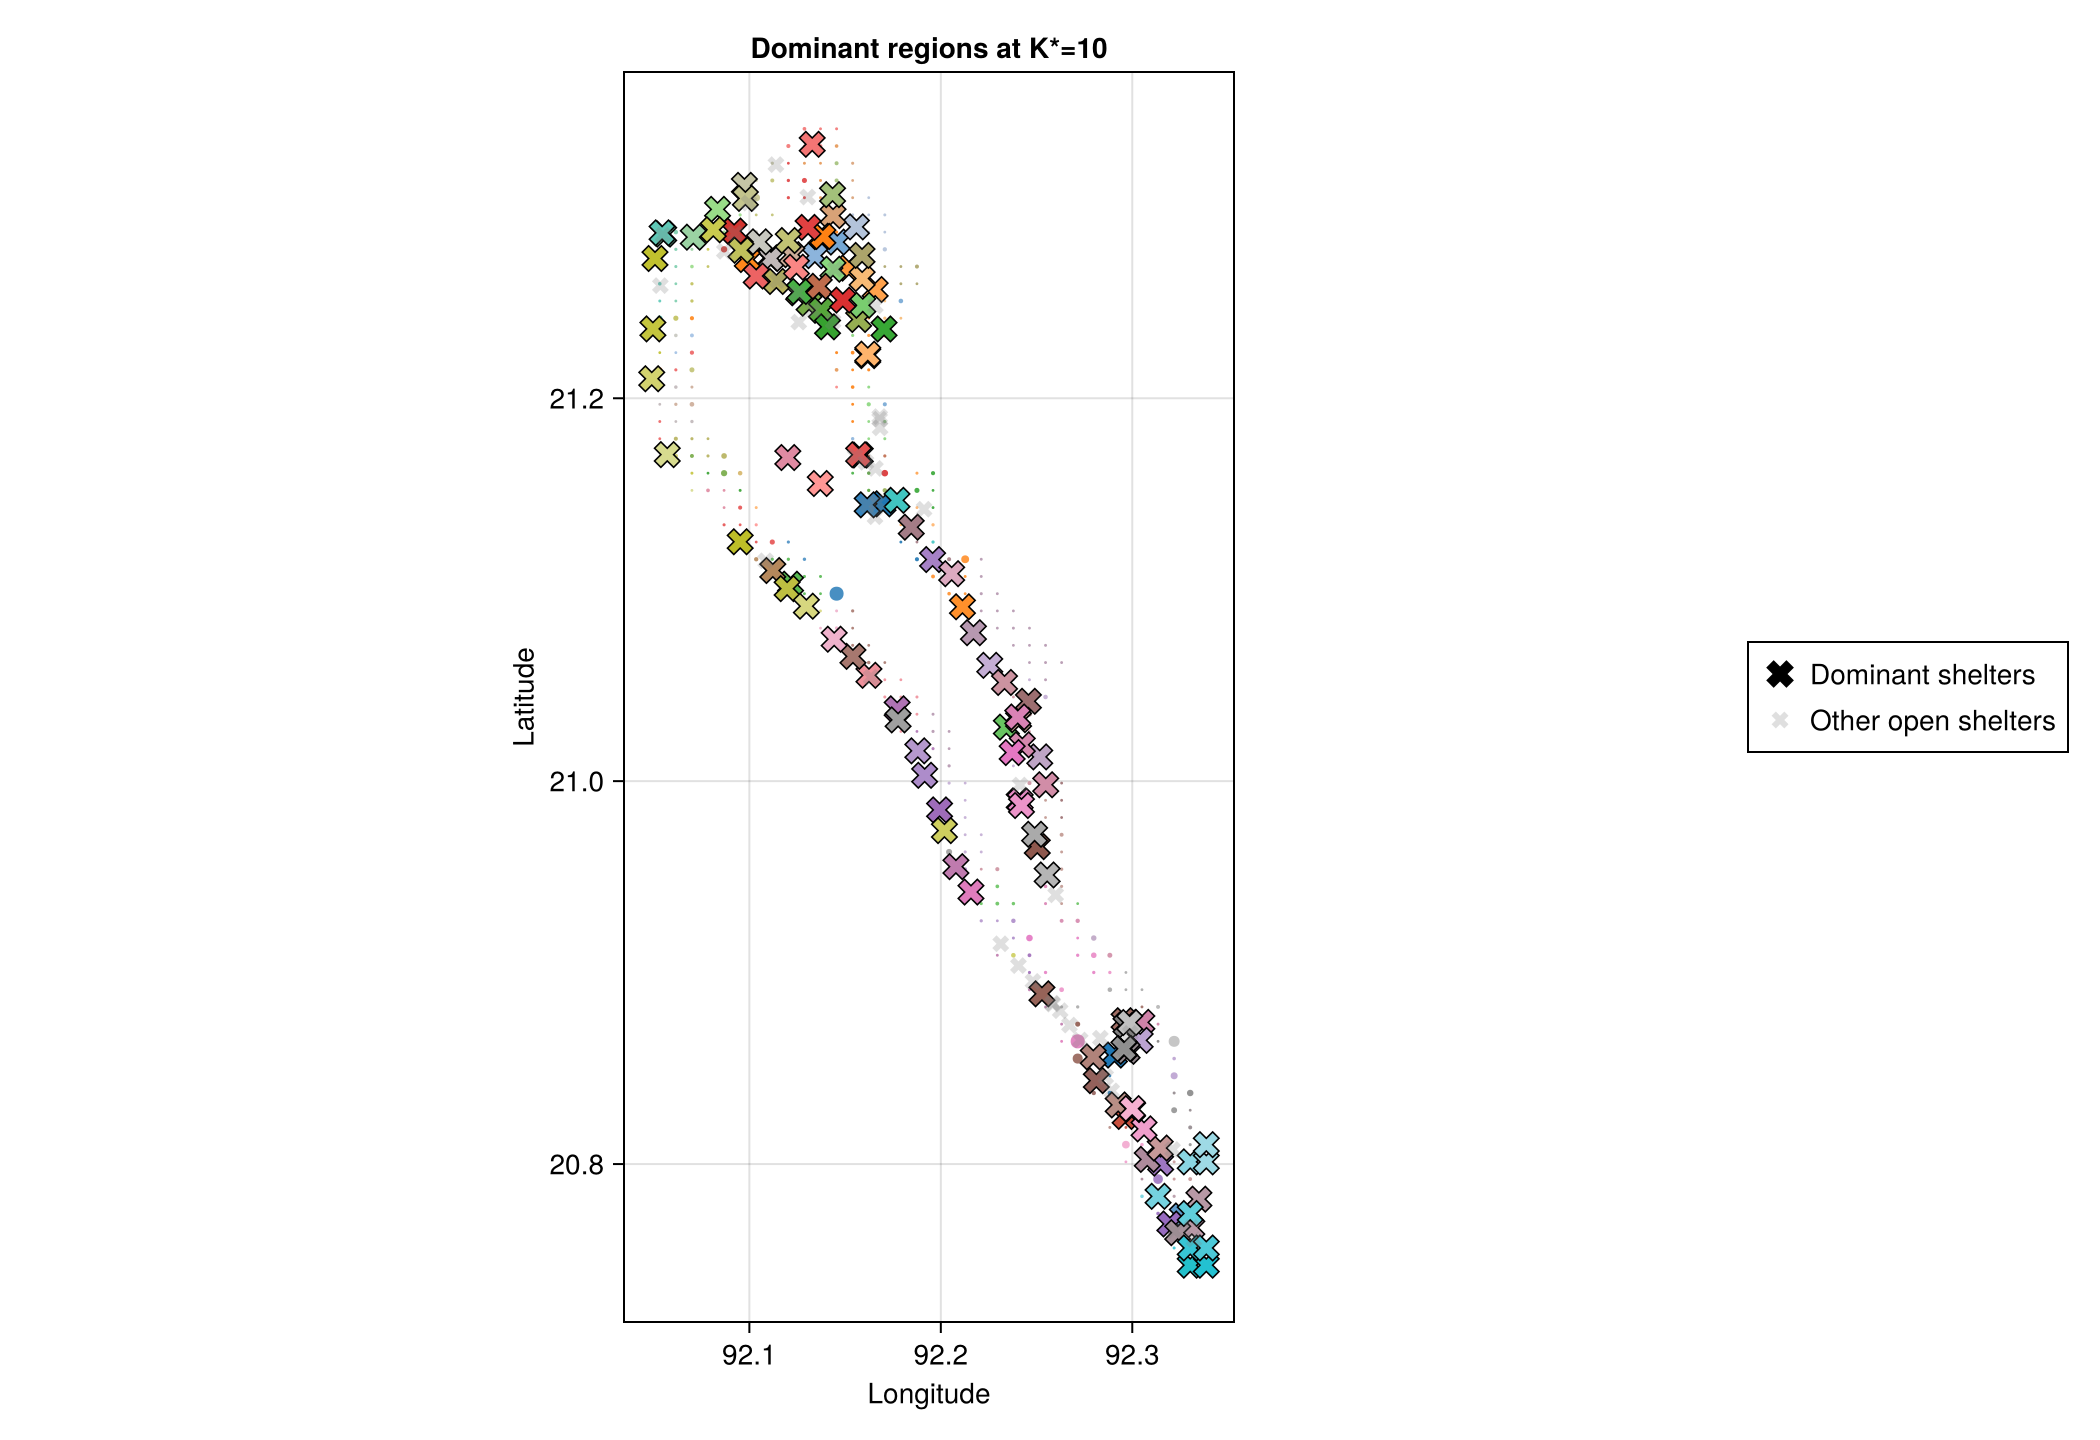


Dominant-region rows (each grid cell i -> dominant shelter dom_j):
381×6 DataFrame
 Row │ i      lon      lat      pop    dom_j  group 
     │ Int64  Float64  Float64  Int64  Int64  Int64 
─────┼──────────────────────────────────────────────
   1 │     1  92.3303  20.7472   1211    162    118
   2 │     2  92.3387  20.7472   5689    163    119
   3 │     3  92.3219  20.7562    210    165    120
   4 │     4  92.3303  20.7562     29    165    120
   5 │     5  92.3387  20.7562   3244    166    121
   6 │     6  92.3135  20.7652      4     76     54
   7 │     7  92.3219  20.7652   9457    122     91
   8 │     8  92.3303  20.7652    285    120     89
   9 │     9  92.3135  20.7742    799     76     54
  10 │    10  92.3219  20.7742   1611     13      5
  11 │    11  92.3303  20.7742   3390    172    122
  12 │    12  92.3051  20.7832    737    174    123
  13 │    13  92.3135  20.7832   1796    174    123
  14 │    14  92.3219  20.7832    344    121     90
  15 │    15  92.3303  20.783

In [51]:
# collect figs for display
figs_cad = Figure[]

# Baseline figs (K=0)
push!(figs_cad, plot_coverage_maps(sol_base; title_prefix="Baseline (K=0): "))
push!(figs_cad, plot_assignments(sol_base; title="Assignments baseline (K=0)"))

# dominant baseline map (figure only)
fig_dom_base = plot_dominant_map(sol_base; title="Dominant regions baseline (K=0)")
push!(figs_cad, fig_dom_base)


# Elbow-best / K* figs
push!(figs_cad, plot_coverage_maps(sol_star; title_prefix="Elbow best (K=$K_star): "))
push!(figs_cad, plot_assignments(sol_star; title="Assignments elbow-best (K=$K_star)"))

# dominant K* map + tables
fig_dom_star, dom_df_star, shelter_summary_star = plot_dominant_map(
    sol_star;
    title="Dominant regions at K*=$K_star",
    return_tables=true
)
push!(figs_cad, fig_dom_star)
foreach(display, figs_cad)

# print the dominance tables for K*
println("\nDominant-region rows (each grid cell i -> dominant shelter dom_j):")
show(dom_df_star, allrows=true, allcols=true)

println("\nSummary by dominant shelter:")
show(shelter_summary_star, allrows=true, allcols=true)

In [52]:
# new_coords_df: the indices + (lon, lat) of all new shelters opened in the K* solution.

# masks
new_mask = [j in JN for j in 1:nJ]          # true if candidate-new shelter
existing_mask = .!new_mask                 # true if original existing shelter

# open vectors
open_base = round.(Int, sol_base.y) .== 1
open_star = round.(Int, sol_star.y) .== 1

# New shelters opened at K*
open_new_star = open_star .& new_mask
new_inds = findall(open_new_star)

new_coords_df = DataFrame(
    shelter_index = new_inds,
    lon = lonJ[new_inds],
    lat = latJ[new_inds]
)

println("New shelters opened in K* = $K_star")
show(new_coords_df, allrows=true, allcols=true)

New shelters opened in K* = 10
10×3 DataFrame
 Row │ shelter_index  lon      lat     
     │ Int64          Float64  Float64 
─────┼─────────────────────────────────
   1 │           162  92.3303  20.7472
   2 │           163  92.3387  20.7472
   3 │           165  92.3303  20.7562
   4 │           166  92.3387  20.7562
   5 │           168  92.3219  20.7652
   6 │           172  92.3303  20.7742
   7 │           174  92.3135  20.7832
   8 │           185  92.3303  20.8011
   9 │           186  92.3387  20.8011
  10 │           192  92.3387  20.8101

In [53]:
# closed_existing_df: which baseline-existing shelters (open at K=0) are no longer open at K*.

# Existing shelters open at K=0 but NOT used/open in K* solution
open_existing_base = open_base .& existing_mask
open_existing_star = open_star .& existing_mask

existing_base_inds = findall(open_existing_base)
existing_star_inds = findall(open_existing_star)

# Existing shelters that were open in baseline but are CLOSED in K*
closed_existing_inds = setdiff(existing_base_inds, existing_star_inds)

closed_existing_df = DataFrame(
    shelter_index = closed_existing_inds,
    lon = lonJ[closed_existing_inds],
    lat = latJ[closed_existing_inds]
)

println("Existing shelters open at K=0 but CLOSED at K*")
show(closed_existing_df, allrows=true, allcols=true)

Existing shelters open at K=0 but CLOSED at K*
0×3 DataFrame
 Row │ shelter_index  lon      lat     
     │ Int64          Float64  Float64 
─────┴─────────────────────────────────

In [54]:
# unused_existing_df: baseline-existing shelters that are effectively not used at K* bc they get ~0 assigned population, even if open.

# Check "not used" via assignments, not just open
# (open but zero assigned population)
pop_assigned_star = [
    sum(d[i] * sol_star.x[i,j] for i in 1:nI) for j in 1:nJ
]

used_star_mask = pop_assigned_star .> 1e-6

# existing shelters that were open at K=0 but receive ~0 pop at K*
unused_existing_inds = [
    j for j in existing_base_inds if !used_star_mask[j]
]

unused_existing_df = DataFrame(
    shelter_index = unused_existing_inds,
    lon = lonJ[unused_existing_inds],
    lat = latJ[unused_existing_inds],
    pop_assigned = pop_assigned_star[unused_existing_inds]
)

println("Existing shelters open at K=0 but UNUSED at K* (pop≈0)")
show(unused_existing_df, allrows=true, allcols=true)

Existing shelters open at K=0 but UNUSED at K* (pop≈0)
0×4 DataFrame
 Row │ shelter_index  lon      lat      pop_assigned 
     │ Int64          Float64  Float64  Float64      
─────┴───────────────────────────────────────────────